Loading data...
Loaded and processed 36000 baseline records.
Loaded and processed 3600 adaptive records.

Generating goodput comparison charts...
Found static configurations: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Saved 5 RPS chart: RQ1_figures/goodput_comparison_5rps.png (600 DPI)
Saved 5 RPS PDF version: RQ1_figures/goodput_comparison_5rps.pdf


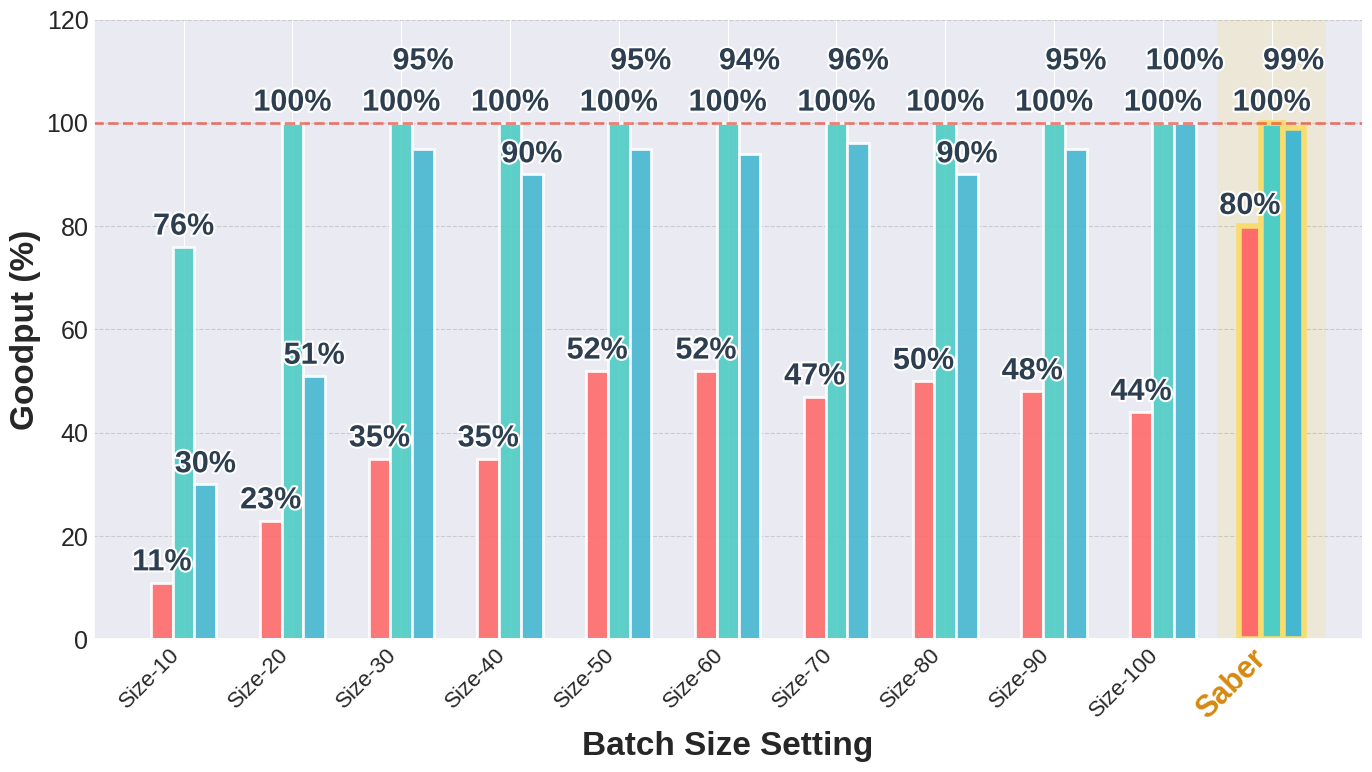

Saved 10 RPS chart: RQ1_figures/goodput_comparison_10rps.png (600 DPI)
Saved 10 RPS PDF version: RQ1_figures/goodput_comparison_10rps.pdf


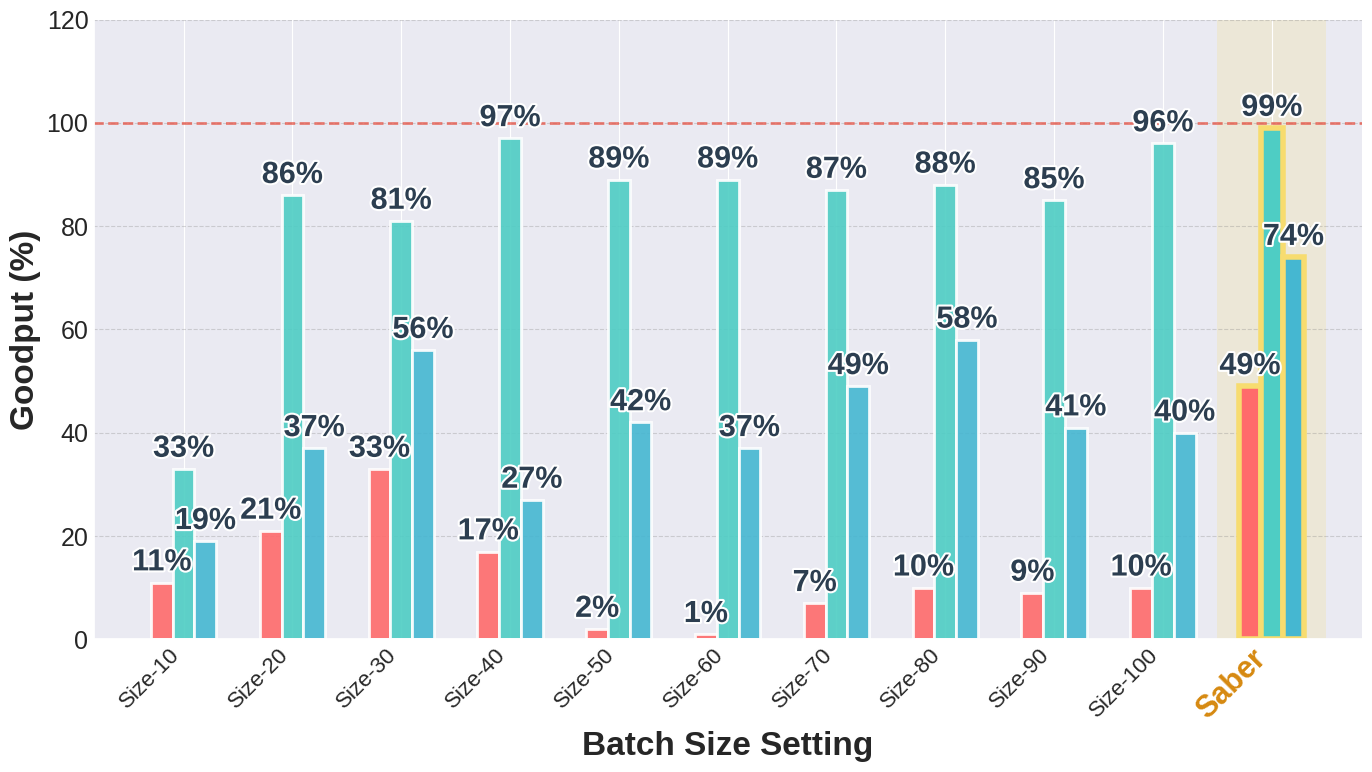

Saved 20 RPS chart: RQ1_figures/goodput_comparison_20rps.png (600 DPI)
Saved 20 RPS PDF version: RQ1_figures/goodput_comparison_20rps.pdf


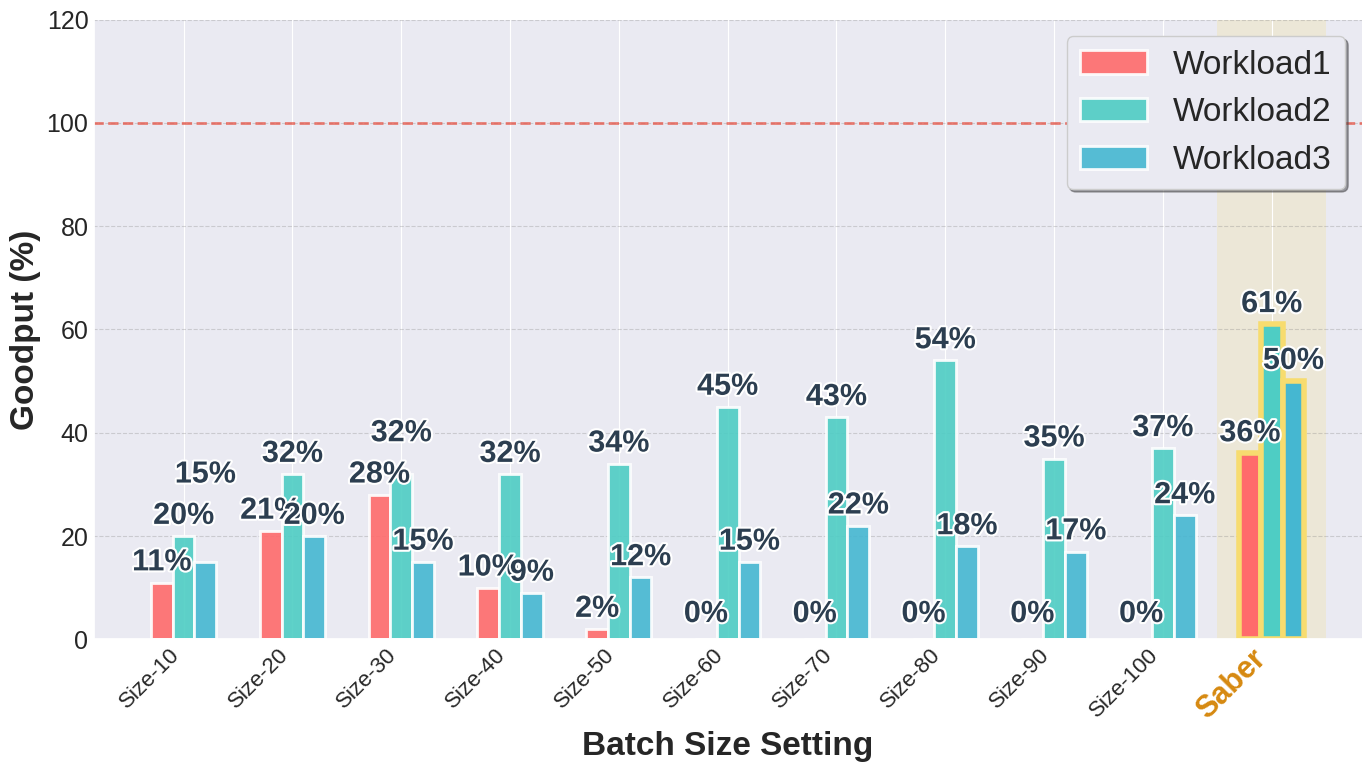


All charts have been created and saved in 'RQ1_figures' directory!


In [2]:
import os
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.patches import Rectangle
from matplotlib import patheffects
warnings.filterwarnings('ignore')

# Use modern style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.size'] = 16

# ================ Global Definitions for SLA ================
task_mapping = {
    'short_input_short_output': 'CodeQnA',
    'long_input_short_output': 'CodeSummary',
    'short_input_long_output': 'CodeGen',
    'long_input_long_output': 'CodeTranslation',
    'CodeQnA': 'CodeQnA',
    'CodeSummary': 'CodeSummary',
    'CodeGen': 'CodeGen',
    'CodeTranslation': 'CodeTranslation'
}

sla_thresholds = {
    'CodeQnA': 1000,
    'CodeSummary': 1000,
    'CodeGen': 8000,
    'CodeTranslation': 12000
}

# ================ Data Loading Functions ================
def load_baseline_data(baseline_dir="baseline_experiment_results"):
    all_data = []
    if not os.path.exists(baseline_dir):
        print(f"Warning: Directory {baseline_dir} does not exist")
        return pd.DataFrame()
    
    concurrency_dirs = glob.glob(os.path.join(baseline_dir, "max_concurrency_*"))
    for concurrency_dir in concurrency_dirs:
        concurrency_match = re.search(r"max_concurrency_(\d+)", os.path.basename(concurrency_dir))
        if not concurrency_match: continue
        concurrency = int(concurrency_match.group(1))
        
        workload_dirs = glob.glob(os.path.join(concurrency_dir, "workload*"))
        for workload_dir in workload_dirs:
            workload = os.path.basename(workload_dir)
            csv_files = glob.glob(os.path.join(workload_dir, "*.csv"))
            
            for csv_file in csv_files:
                filename = os.path.basename(csv_file)
                rps_match = re.search(r'rps_?(\d+\.?\d*)', filename)
                rps = float(rps_match.group(1)) if rps_match else None
                
                df = process_file(csv_file, workload, concurrency, "baseline")
                if not df.empty:
                    df['RPS'] = rps
                    all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

def load_agent_data(agent_dir="agent_data"):
    all_data = []
    if not os.path.exists(agent_dir):
        print(f"Warning: Directory {agent_dir} does not exist")
        return pd.DataFrame()
    
    csv_files = glob.glob(os.path.join(agent_dir, "*.csv"))
    for csv_file in csv_files:
        filename = os.path.basename(csv_file)
        workload_match = re.search(r'(workload\d+)', filename)
        if not workload_match: continue
        workload = workload_match.group(1)
        
        rps_match = re.search(r'rps_?(\d+\.?\d*)', filename)
        rps = float(rps_match.group(1)) if rps_match else None
        
        df = process_file(csv_file, workload, concurrency="adaptive", experiment_type="adaptive")
        if not df.empty:
            df['RPS'] = rps
            all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

def process_file(csv_file, workload, concurrency, experiment_type):
    try:
        df = pd.read_csv(csv_file)
        if df.empty: return pd.DataFrame()
        
        df.columns = [col.strip() for col in df.columns]
        
        # Clean thread ID data
        if 'Thread ID' in df.columns or 'Thread_ID' in df.columns:
            thread_col = 'Thread ID' if 'Thread ID' in df.columns else 'Thread_ID'
            df = df[pd.to_numeric(df[thread_col], errors='coerce').notna()]
        
        # Clean request type data
        if 'Request Type' in df.columns or 'Request_Type' in df.columns:
            req_col = 'Request Type' if 'Request Type' in df.columns else 'Request_Type'
            df = df[df[req_col].notna()]
            df = df[~df[req_col].astype(str).str.contains('Summary|Expected Duration|Last Request|Total Experiment|Target RPS|Actual RPS', case=False, na=False)]
        
        # Standardize column names
        column_mapping = {
            'Thread ID': 'Thread_ID', 'Request Type': 'Request_Type',
            'Waiting Time': 'Waiting_Time', 'Execution Time': 'Execution_Time',
            'Total Round Trip Time': 'Total_Time', 'SLA Time': 'SLA_Time',
            'Low Priority': 'Low_Priority', 'SLA Met': 'SLA_Met'
        }
        df = df.rename(columns=column_mapping)
        
        # Ensure required columns
        required_cols = ['Thread_ID', 'Request_Type', 'Total_Time']
        for col in required_cols:
            if col in df.columns: df = df[df[col].notna()]
        
        # Process SLA_Met column
        if 'SLA_Met' in df.columns:
            if pd.api.types.is_string_dtype(df['SLA_Met']) or pd.api.types.is_object_dtype(df['SLA_Met']):
                 df['SLA_Met'] = df['SLA_Met'].astype(str).str.lower().map({
                    'yes': True, 'true': True, '1': True, '1.0': True,
                    'no': False, 'false': False, '0': False, '0.0': False,
                    True: True, False: False
                }).fillna(False)
            df['SLA_Met'] = df['SLA_Met'].astype(bool)

        # Convert time columns to milliseconds if needed
        time_columns = ['Waiting_Time', 'Execution_Time', 'Total_Time', 'SLA_Time']
        for col in time_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                if df[col].notna().any() and df[col][df[col].notna()].max() < 100:
                    df.loc[df[col].notna(), col] = df.loc[df[col].notna(), col] * 1000
        
        df['Workload'] = workload
        df['Concurrency_Config'] = concurrency
        df['Experiment_Type'] = experiment_type
        
        return df
    except Exception as e:
        print(f"Error processing file {csv_file}: {str(e)}")
        return pd.DataFrame()

def add_sla_columns(df):
    df = df.copy()
    df['Task_Type'] = df['Request_Type'].map(task_mapping)
    if df['Task_Type'].isnull().any():
        df['Task_Type'] = df['Task_Type'].fillna('CodeQnA')
    
    df['SLA_Threshold'] = df['Task_Type'].map(sla_thresholds)
    
    if 'SLA_Met' not in df.columns or df['SLA_Met'].isnull().all():
        df['SLA_Met'] = df['Total_Time'] <= df['SLA_Threshold']
    else:
        if pd.api.types.is_string_dtype(df['SLA_Met']) or pd.api.types.is_object_dtype(df['SLA_Met']):
             df['SLA_Met'] = df['SLA_Met'].astype(str).str.lower().map({
                'yes': True, 'true': True, '1': True, '1.0': True,
                'no': False, 'false': False, '0': False, '0.0': False,
                True: True, False: False
            }).fillna(False).astype(bool)
        else:
            df['SLA_Met'] = df['SLA_Met'].astype(bool)
            
    df['SLA_Utilization'] = df['Total_Time'] / df['SLA_Threshold']
    return df

# ================ Plotting Functions ================
def plot_goodput_comparison(baseline_df, adaptive_df, target_rps_list=[5, 10, 20], save_fig=False, output_dir="."):
    """
    Create goodput comparison charts for different RPS levels
    """
    # Color scheme
    workload_colors = {
        'workload1': '#FF6B6B',  # Coral red
        'workload2': '#4ECDC4',  # Turquoise
        'workload3': '#45B7D1',  # Sky blue
    }
    
    # Saber's special color
    saber_color = '#F7DC6F'  # Golden yellow
    
    # Font sizes
    FONT_TITLE = 28        
    FONT_AXIS_LABEL = 24   
    FONT_TICK_LABEL = 18   
    FONT_LEGEND = 24       
    FONT_BAR_LABEL = 22    

    # Get all baseline configurations
    all_baseline_configs_numeric = sorted(
        [c for c in baseline_df['Concurrency_Config'].unique() if isinstance(c, (int, float)) and c != 'adaptive'],
        key=int
    )
    
    if not all_baseline_configs_numeric:
        all_baseline_configs_numeric = list(range(10, 101, 10))
    
    print(f"Found static configurations: {all_baseline_configs_numeric}")

    # Create separate plots for each RPS
    for target_rps in target_rps_list:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8), facecolor='white')
        
        displayed_static_configs = all_baseline_configs_numeric
        config_names = [f'Size-{c}' for c in displayed_static_configs] + ['Saber']
        num_configs = len(config_names)

        # Collect data
        goodput_data = {config_name: {wk: 0 for wk in workload_colors.keys()} for config_name in config_names}

        for config_name in config_names:
            for workload_key in workload_colors.keys():
                df_slice = None
                if config_name == 'Saber':
                    df_slice = adaptive_df[
                        (adaptive_df['Workload'] == workload_key) &
                        (adaptive_df['RPS'] == target_rps)
                    ]
                else:
                    concurrency_val = int(config_name.split('-')[1])
                    df_slice = baseline_df[
                        (baseline_df['Workload'] == workload_key) &
                        (baseline_df['RPS'] == target_rps) &
                        (baseline_df['Concurrency_Config'] == concurrency_val)
                    ]
                
                if df_slice is not None and not df_slice.empty and 'SLA_Met' in df_slice.columns:
                    goodput_data[config_name][workload_key] = df_slice['SLA_Met'].mean() * 100

        # Set up bar positions
        x = np.arange(num_configs)
        num_workloads = len(workload_colors)
        total_bar_width = 0.6 if num_configs > 8 else 0.8
        bar_width = total_bar_width / num_workloads
        
        # Plot bars
        all_labels_info = []
        
        for i, (workload_key, color) in enumerate(workload_colors.items()):
            values = [goodput_data[config_name][workload_key] for config_name in config_names]
            bar_positions = x + (i - num_workloads/2 + 0.5) * bar_width
            
            bars = ax.bar(bar_positions, values, bar_width,
                          label=workload_key.capitalize(),
                          color=color,
                          edgecolor='white',
                          linewidth=2,
                          alpha=0.9)
            
            # Special effect for Saber
            if 'Saber' in config_names:
                saber_idx = config_names.index('Saber')
                bars[saber_idx].set_edgecolor(saber_color)
                bars[saber_idx].set_linewidth(4)
                bars[saber_idx].set_alpha(1.0)
            
            # Collect label info
            for j, bar in enumerate(bars):
                height = bar.get_height()
                x_pos = bar.get_x() + bar.get_width()/2.
                all_labels_info.append({
                    'x': x_pos,
                    'y': height,
                    'text': f'{height:.0f}%',
                    'config_idx': j,
                    'workload_idx': i
                })
        
        # Smart label placement
        placed_labels = []
        for label_info in all_labels_info:
            x_pos = label_info['x']
            y_pos = label_info['y'] + 1
            
            if label_info['y'] == 0:
                y_pos = 2
            
            # Check for overlaps
            for placed in placed_labels:
                if abs(placed['x'] - x_pos) < bar_width * 1.5 and abs(placed['y'] - y_pos) < 8:
                    y_pos = placed['y'] + 8
            
            # Add text with shadow
            text = ax.text(x_pos, y_pos,
                          label_info['text'],
                          ha='center', va='bottom',
                          fontsize=FONT_BAR_LABEL,
                          fontweight='bold',
                          color='#2C3E50')
            text.set_path_effects([patheffects.withStroke(linewidth=3, foreground='white')])
            
            placed_labels.append({'x': x_pos, 'y': y_pos})

        # Customize chart
        ax.set_xlabel('Batch Size Setting', fontsize=FONT_AXIS_LABEL, fontweight='bold')
        ax.set_ylabel('Goodput (%)', fontsize=FONT_AXIS_LABEL, fontweight='bold')
        
        # Set x-axis labels
        ax.set_xticks(x)
        if num_configs > 8:
            ax.set_xticklabels(config_names, fontsize=FONT_TICK_LABEL-2, rotation=45, ha='right')
        else:
            ax.set_xticklabels(config_names, fontsize=FONT_TICK_LABEL)
        
        # Highlight Saber label
        if 'Saber' in config_names:
            labels = ax.get_xticklabels()
            saber_idx = config_names.index('Saber')
            labels[saber_idx].set_fontweight('bold')
            labels[saber_idx].set_fontsize(FONT_TICK_LABEL + 4)
            labels[saber_idx].set_color('#D68910')
            
            # Add background highlight for Saber
            rect = Rectangle((saber_idx - 0.5, -5), 1, 135,
                           facecolor=saber_color, alpha=0.2, zorder=0)
            ax.add_patch(rect)
        
        # Set y-axis
        ax.set_ylim(0, 120)
        ax.yaxis.set_ticks(range(0, 121, 20))
        ax.tick_params(axis='y', labelsize=FONT_TICK_LABEL)
        
        # Add grid
        ax.grid(True, axis='y', linestyle='--', alpha=0.3, color='gray')
        ax.set_axisbelow(True)
        
        # Add 100% reference line
        ax.axhline(y=100, color='#E74C3C', linestyle='--', linewidth=2, alpha=0.7, label='100% Target')
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        
        # Add legend only for RPS=20
        if target_rps == 20:
            handles, labels = ax.get_legend_handles_labels()
            handles = [h for h, l in zip(handles, labels) if l != '100% Target']
            labels = [l for l in labels if l != '100% Target']
            ax.legend(handles, labels, loc='upper right', fontsize=FONT_LEGEND,
                     frameon=True, fancybox=True, shadow=True)

        plt.tight_layout()
        
        if save_fig:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            
            # Save high-resolution PNG
            save_path = os.path.join(output_dir, f'goodput_comparison_{target_rps}rps.png')
            plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='none')
            print(f"Saved {target_rps} RPS chart: {save_path} (600 DPI)")
            
            # Save PDF version
            pdf_path = os.path.join(output_dir, f'goodput_comparison_{target_rps}rps.pdf')
            plt.savefig(pdf_path, format='pdf', bbox_inches='tight', facecolor='white', edgecolor='none')
            print(f"Saved {target_rps} RPS PDF version: {pdf_path}")
        
        plt.show()

# ================ Main Execution ================
if __name__ == "__main__":
    baseline_data_dir = "experiment_data/baseline_experiment_results/"
    adaptive_data_dir = "experiment_data/saber_data_USL/"
    output_figure_dir = "RQ1_figures"

    print("Loading data...")
    baseline_df_raw = load_baseline_data(baseline_data_dir)
    adaptive_df_raw = load_agent_data(adaptive_data_dir)

    processed_baseline_df = pd.DataFrame()
    if not baseline_df_raw.empty:
        processed_baseline_df = add_sla_columns(baseline_df_raw)
        print(f"Loaded and processed {len(processed_baseline_df)} baseline records.")
    else:
        print(f"Warning: Baseline DataFrame is empty. Check path: {baseline_data_dir}")

    processed_adaptive_df = pd.DataFrame()
    if not adaptive_df_raw.empty:
        processed_adaptive_df = add_sla_columns(adaptive_df_raw)
        print(f"Loaded and processed {len(processed_adaptive_df)} adaptive records.")
    else:
        print(f"Warning: Adaptive DataFrame is empty. Check path: {adaptive_data_dir}")

    if processed_baseline_df.empty and processed_adaptive_df.empty:
        print("No data available for plotting! Exiting.")
        exit()
    
    print("\nGenerating goodput comparison charts...")
    plot_goodput_comparison(
        processed_baseline_df,
        processed_adaptive_df,
        target_rps_list=[5, 10, 20], 
        save_fig=True,
        output_dir=output_figure_dir
    )
    
    print(f"\nAll charts have been created and saved in '{output_figure_dir}' directory!")

Loading baseline data from: experiment_data/baseline_experiment_results...

Loading Saber (adaptive) data from: experiment_data/saber_data_USL...

Generating CDF grid comparing Saber with specific baseline configurations...

Generating CDF grid with refined label positioning...


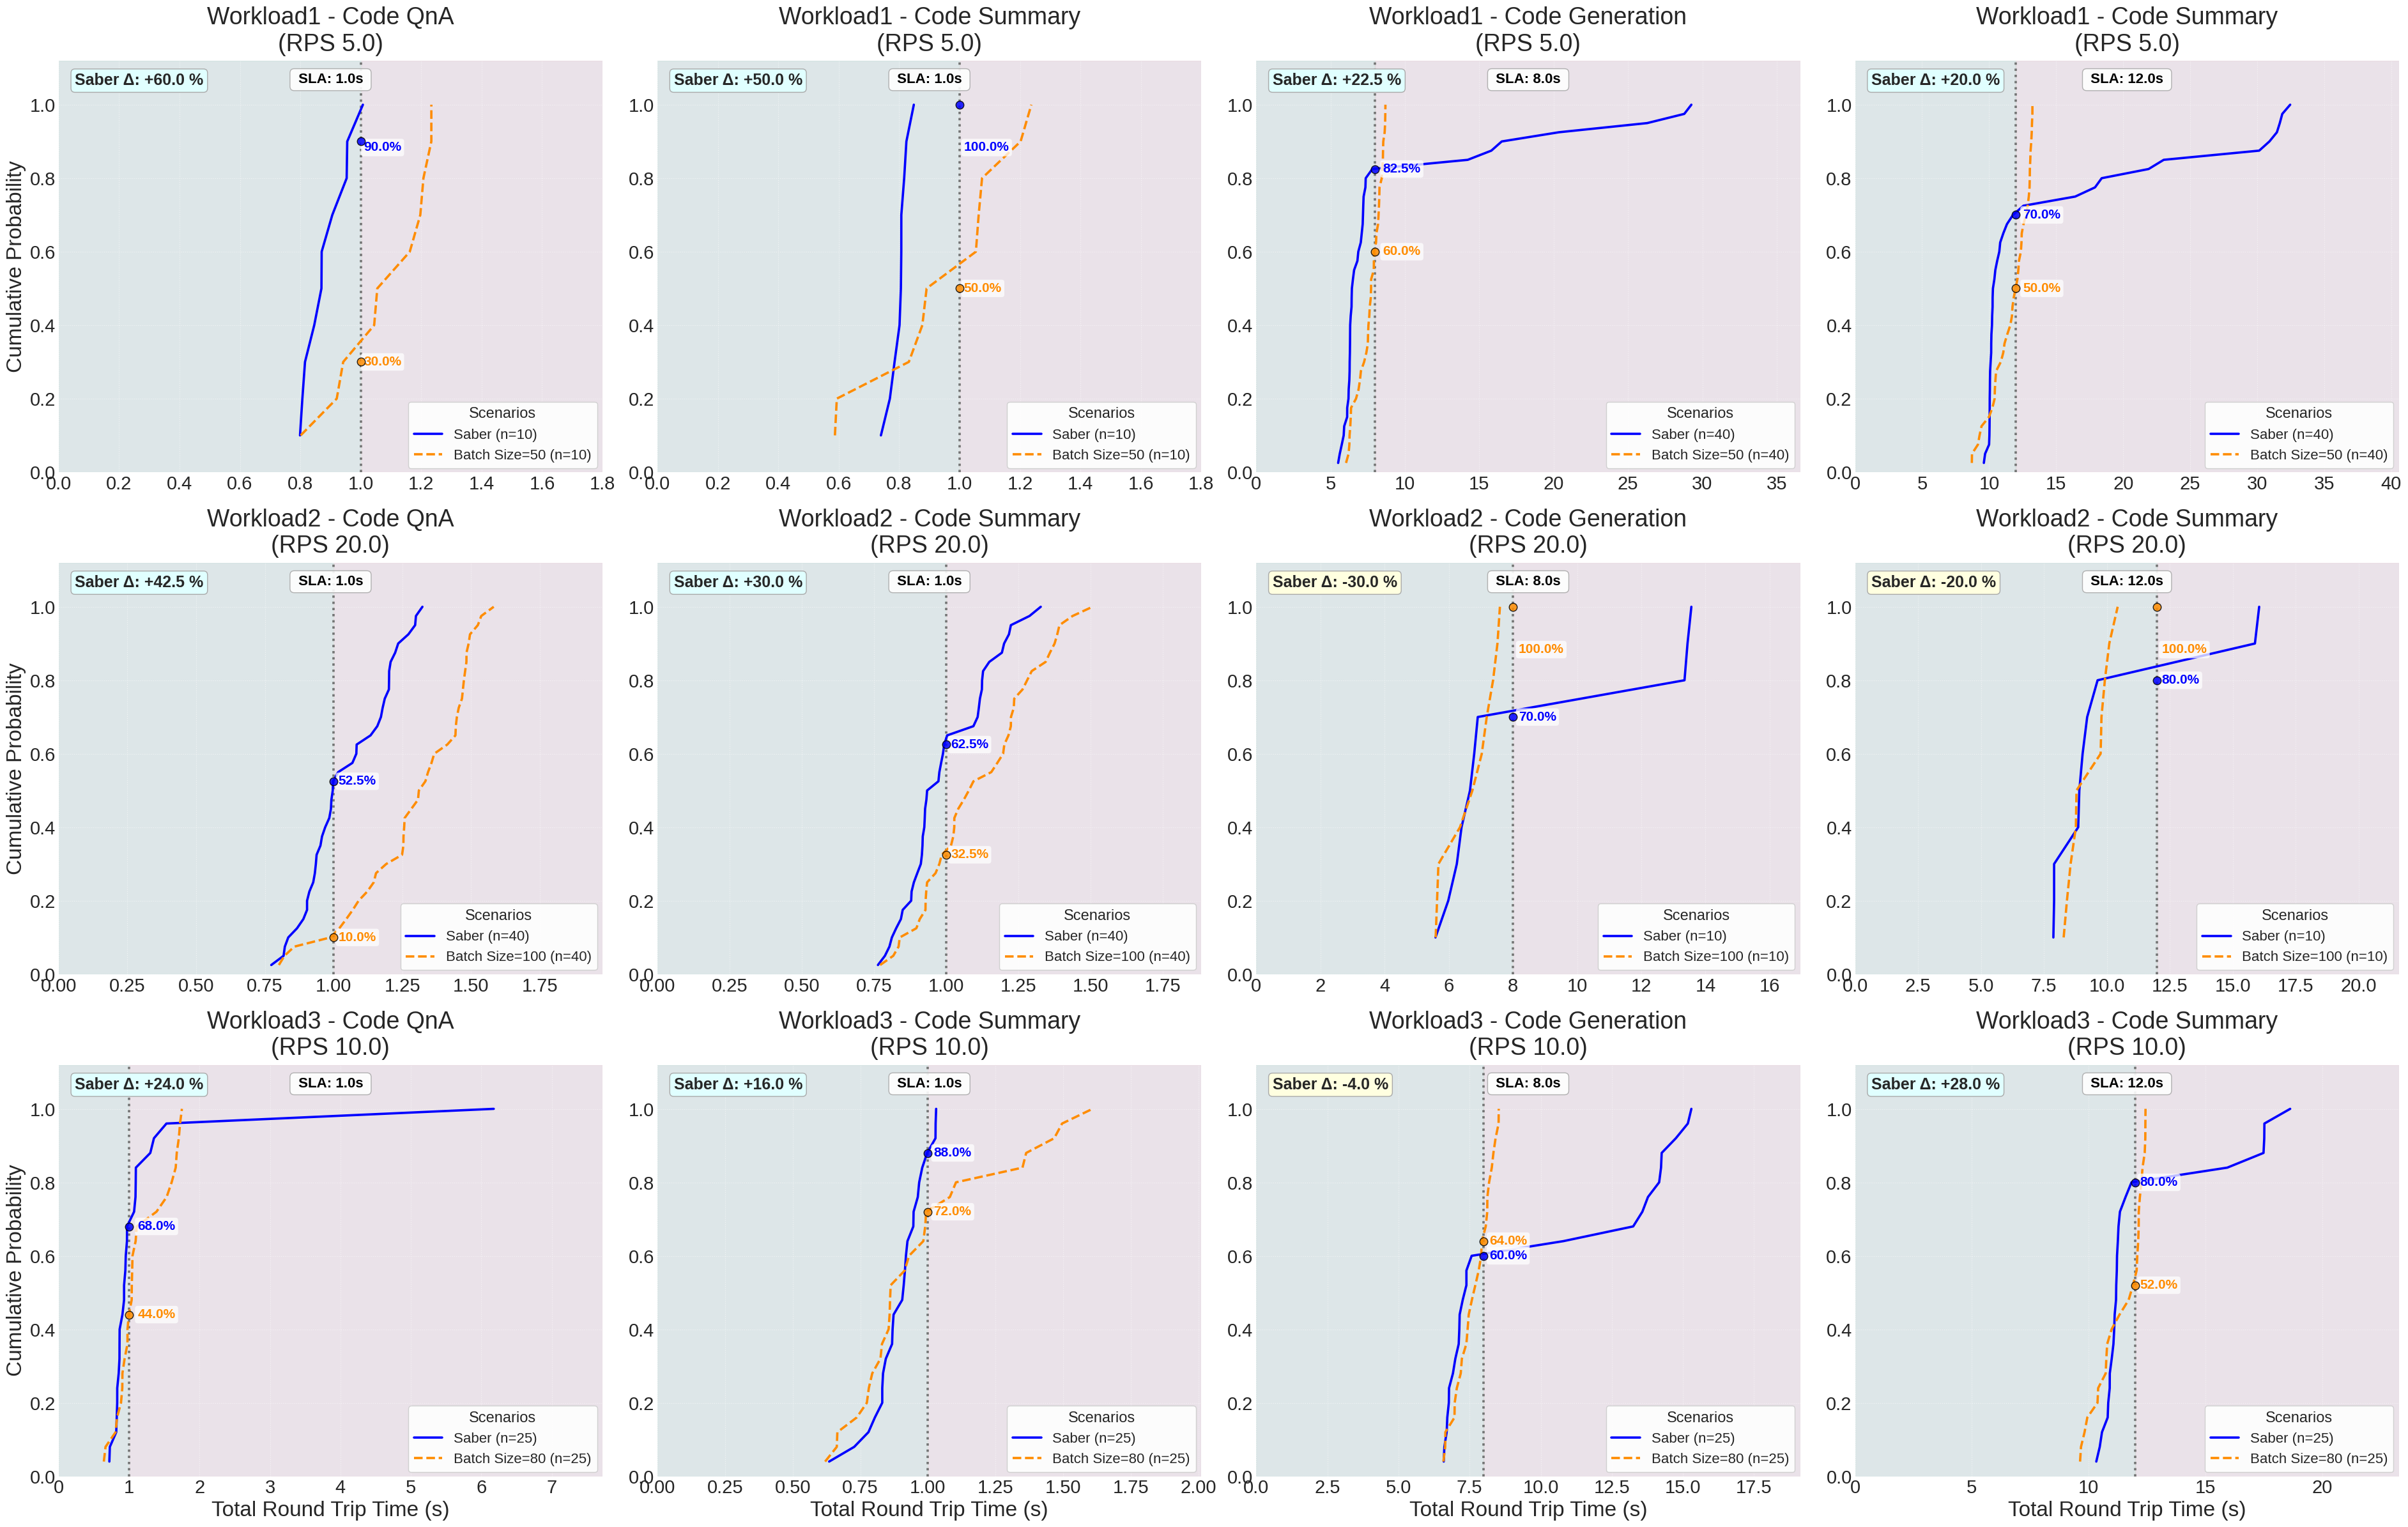


--- Summary Statistics (SLA Met Rate %) ---

WORKLOAD1 @ RPS 5.0:
  Saber (overall): 100 requests, SLA met: 80.0%
    Task 'Code QnA': 10 requests, SLA met: 90.0%
    Task 'Code Summary': 10 requests, SLA met: 100.0%
    Task 'Code Generation': 40 requests, SLA met: 82.5%
    Task 'Code Summary': 40 requests, SLA met: 70.0%
  Static Baseline (C=50):
    Overall: 106 requests, SLA met: 49.1%
      Task 'Code QnA': 10 requests, SLA met: 30.0%
      Task 'Code Summary': 10 requests, SLA met: 50.0%
      Task 'Code Generation': 40 requests, SLA met: 60.0%
      Task 'Code Summary': 40 requests, SLA met: 50.0%
      Task 'nan': 0 requests, SLA met: 0.0%
      Task '20.00s': 1 requests, SLA met: 0.0%
      Task '19.89s': 1 requests, SLA met: 0.0%
      Task '28.60s': 1 requests, SLA met: 0.0%
      Task '5': 1 requests, SLA met: 0.0%
      Task '5.03': 1 requests, SLA met: 0.0%

WORKLOAD2 @ RPS 20.0:
  Saber (overall): 100 requests, SLA met: 61.0%
    Task 'Code Summary': 40 requests, SLA m

In [5]:
import os
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ================ Global Definitions for SLA ================
task_mapping = {
    'short_input_short_output': 'CodeQnA',
    'long_input_short_output': 'CodeSummary',
    'short_input_long_output': 'CodeGen',
    'long_input_long_output': 'CodeTranslation',
    'CodeQnA': 'CodeQnA',
    'CodeSummary': 'CodeSummary',
    'CodeGen': 'CodeGen',
    'CodeTranslation': 'CodeTranslation'
}

task_display_names = {
    'CodeQnA': 'Code QnA',           
    'CodeSummary': 'Code Summary',
    'CodeGen': 'Code Generation',
    'CodeTranslation': 'Code Summary'
}

sla_thresholds = {
    'CodeQnA': 1000,      # 1 second (in ms)
    'CodeSummary': 1000,  # 1 second (in ms)
    'CodeGen': 8000,      # 8 seconds (in ms)
    'CodeTranslation': 12000 # 12 seconds (in ms)
}

# ================ Specific Configurations for Comparison (Unchanged) ================
WORKLOAD_SPECIFIC_COMPARISONS = {
    'workload1': {'rps': 5.0, 'baseline_concurrency': 50},
    'workload2': {'rps': 20.0, 'baseline_concurrency': 100},
    'workload3': {'rps': 10.0, 'baseline_concurrency': 80}
}

# ================ Data Loading Functions (Unchanged) ================
def load_baseline_data(baseline_dir="baseline_experiment_results"):
    all_data = []
    if not os.path.exists(baseline_dir):
        return pd.DataFrame()
    concurrency_dirs = glob.glob(os.path.join(baseline_dir, "max_concurrency_*"))
    for concurrency_dir in concurrency_dirs:
        concurrency_match = re.search(r"max_concurrency_(\d+)", os.path.basename(concurrency_dir))
        if not concurrency_match:
            continue
        concurrency = int(concurrency_match.group(1))
        workload_dirs = glob.glob(os.path.join(concurrency_dir, "workload*"))
        for workload_dir in workload_dirs:
            workload = os.path.basename(workload_dir)
            csv_files = glob.glob(os.path.join(workload_dir, "*.csv"))
            for csv_file in csv_files:
                filename = os.path.basename(csv_file)
                rps_match = re.search(r'rps_?(\d+\.?\d*)', filename)
                rps = float(rps_match.group(1)) if rps_match else None
                df = process_file(csv_file, workload, concurrency, "baseline")
                if not df.empty:
                    df['RPS'] = rps
                    all_data.append(df)
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

def load_agent_data(agent_dir="agent_data"):
    all_data = []
    if not os.path.exists(agent_dir):
        return pd.DataFrame()
    csv_files = glob.glob(os.path.join(agent_dir, "*.csv"))
    for csv_file in csv_files:
        filename = os.path.basename(csv_file)
        workload_match = re.search(r'(workload\d+)', filename)
        if not workload_match:
            continue
        workload = workload_match.group(1)
        rps_match = re.search(r'rps_?(\d+\.?\d*)', filename)
        rps = float(rps_match.group(1)) if rps_match else None
        df = process_file(csv_file, workload, concurrency="adaptive", experiment_type="adaptive")
        if not df.empty:
            df['RPS'] = rps
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

def process_file(csv_file, workload, concurrency, experiment_type):
    try:
        df = pd.read_csv(csv_file)
        if df.empty: return pd.DataFrame()
        df.columns = [col.strip() for col in df.columns]
        column_mapping = {
            'Thread ID': 'Thread_ID', 'Request Type': 'Request_Type',
            'Waiting Time': 'Waiting_Time', 'Execution Time': 'Execution_Time',
            'Total Round Trip Time': 'Total_Time', 'SLA Time': 'SLA_Time',
            'Low Priority': 'Low_Priority', 'SLA Met': 'SLA_Met'
        }
        df = df.rename(columns=column_mapping)
        if 'SLA_Met' in df.columns:
            df['SLA_Met'] = df['SLA_Met'].astype(str).str.lower().map({'yes': True, 'no': False, 'true': True, 'false': False})

        time_columns = ['Waiting_Time', 'Execution_Time', 'Total_Time', 'SLA_Time']
        df_copy = df.copy()
        for col in time_columns:
            if col in df_copy.columns:
                mask = df_copy[col].notna()
                if mask.any():
                    numeric_col = pd.to_numeric(df_copy.loc[mask, col], errors='coerce')
                    if not numeric_col.empty and not numeric_col.isnull().all() and numeric_col.max() < 100: 
                        df_copy.loc[mask, col] = numeric_col * 1000
        df = df_copy

        df['Workload'] = workload
        df['Concurrency_Config'] = concurrency
        df['Experiment_Type'] = experiment_type
        required_columns = ['Request_Type', 'Total_Time']
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            return pd.DataFrame()
        return df
    except Exception as e:
        print(f"Error processing file {csv_file}: {e}")
        return pd.DataFrame()

def add_sla_columns(df):
    df = df.copy()
    df['Task_Type'] = df['Request_Type'].map(task_mapping)
    if df['Task_Type'].isnull().any():
        df['Task_Type'] = df['Task_Type'].fillna(df['Request_Type'].map({v: v for v in task_mapping.values()}))
        df['Task_Type'] = df['Task_Type'].fillna('CodeQnA') 
    df['SLA_Threshold'] = df['Task_Type'].map(sla_thresholds) # In ms
    
    df['Total_Time'] = pd.to_numeric(df['Total_Time'], errors='coerce') # In ms

    if 'SLA_Met' not in df.columns or df['SLA_Met'].isnull().all():
        df['SLA_Met'] = df['Total_Time'] <= df['SLA_Threshold']
    else:
        if df['SLA_Met'].dtype == object or pd.api.types.is_string_dtype(df['SLA_Met']):
            df['SLA_Met'] = df['SLA_Met'].astype(str).str.lower().map(
                {'true': True, 'yes': True, True: True, 1: True, '1': True,
                 'false': False, 'no': False, False: False, 0: False, '0': False}
            )
        df['SLA_Met'] = df['SLA_Met'].astype(bool)
    return df

# ================ CDF Visualization Function (MODIFIED with display names) ================
def plot_cdf_grid(baseline_df, adaptive_df):
    workloads = ['workload1', 'workload2', 'workload3']
    request_types = ['short_input_short_output', 'long_input_short_output',
                     'short_input_long_output', 'long_input_long_output']

    fig, axes = plt.subplots(3, 4, figsize=(38, 26)) 

    saber_color = 'blue'
    baseline_specific_color = 'darkorange'
    saber_style = {'linestyle': '-', 'marker': 'None'}
    baseline_style = {'linestyle': '--', 'marker': 'None'}

    font_scale_factor = 0.75 
    title_fontsize_orig = 36; label_fontsize_orig = 32; tick_label_fontsize_orig = 28
    legend_fontsize_orig = 22; annotation_fontsize_small_orig = 20
    annotation_fontsize_medium_orig = 24; sla_label_fontsize_orig = 22

    title_fontsize = int(title_fontsize_orig * font_scale_factor)
    label_fontsize = int(label_fontsize_orig * font_scale_factor)
    tick_label_fontsize = int(tick_label_fontsize_orig * font_scale_factor)
    legend_fontsize = int(legend_fontsize_orig * font_scale_factor)
    annotation_fontsize_small = int(annotation_fontsize_small_orig * font_scale_factor)
    annotation_fontsize_medium = int(annotation_fontsize_medium_orig * font_scale_factor)
    sla_label_fontsize = int(sla_label_fontsize_orig * font_scale_factor)
    
    min_font_size = 12 
    title_fontsize = max(title_fontsize, min_font_size + 4)
    label_fontsize = max(label_fontsize, min_font_size + 2)
    tick_label_fontsize = max(tick_label_fontsize, min_font_size)
    legend_fontsize = max(legend_fontsize, min_font_size)
    annotation_fontsize_small = max(annotation_fontsize_small, min_font_size -1 if min_font_size > 1 else min_font_size) 
    annotation_fontsize_medium = max(annotation_fontsize_medium, min_font_size)
    sla_label_fontsize = max(sla_label_fontsize, min_font_size)

    y_lim_plot_top = 1.12 
    sla_text_axes_y_pos = 0.97 
    
    percentage_label_y_cap = 0.90 
    approx_text_height = 0.04 

    print("\nGenerating CDF grid with refined label positioning...")

    for row_idx, workload in enumerate(workloads):
        workload_config = WORKLOAD_SPECIFIC_COMPARISONS.get(workload)
        x_axis_label = 'Total Round Trip Time (s)'

        if not workload_config:
            for col_idx_empty in range(len(request_types)):
                ax_idx = row_idx * len(request_types) + col_idx_empty
                ax = axes.flatten()[ax_idx]
                req_type_for_empty_title = request_types[col_idx_empty]
                task_type_name = task_mapping.get(req_type_for_empty_title, req_type_for_empty_title)
              
                display_name = task_display_names.get(task_type_name, task_type_name)
                ax.text(0.5, 0.5, f'No config for\n{workload.capitalize()}', ha='center', va='center', transform=ax.transAxes, fontsize=annotation_fontsize_medium)
                ax.set_title(f'{workload.capitalize()} - {display_name}', fontsize=max(min_font_size, title_fontsize - int(4*font_scale_factor))) 
                ax.set_xlim(0, 10000 / 1000.0) 
                ax.set_ylim(0, y_lim_plot_top) 
                if row_idx == (len(workloads) - 1): ax.set_xlabel(x_axis_label, fontsize=label_fontsize)
                if col_idx_empty == 0: ax.set_ylabel('Cumulative Probability', fontsize=label_fontsize)
                ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize); ax.grid(True, alpha=0.3)
            continue

        current_rps_for_workload = workload_config['rps']
        specific_baseline_concurrency = workload_config['baseline_concurrency']

        for col_idx, req_type in enumerate(request_types):
            ax_idx = row_idx * len(request_types) + col_idx
            ax = axes.flatten()[ax_idx]
            task_type = task_mapping.get(req_type, 'CodeQnA')
           
            display_name = task_display_names.get(task_type, task_type)
            sla_threshold_ms = sla_thresholds.get(task_type, 1000) 
            sla_threshold_s = sla_threshold_ms / 1000.0
            
            df_plot_list = []
            saber_sla_met_overall = None 
            baseline_sla_met_overall = None 

            if not adaptive_df.empty:
                filtered_adaptive = adaptive_df[(adaptive_df['Workload'] == workload) & (adaptive_df['RPS'] == current_rps_for_workload) & (adaptive_df['Request_Type'] == req_type)].copy()
                if not filtered_adaptive.empty:
                    filtered_adaptive['Scenario'] = 'Saber'
                    df_plot_list.append(filtered_adaptive)
                    if 'SLA_Met' in filtered_adaptive.columns and not filtered_adaptive['SLA_Met'].empty:
                        saber_sla_met_series = filtered_adaptive['SLA_Met']
                        if saber_sla_met_series.dtype != bool: 
                            saber_sla_met_series = saber_sla_met_series.astype(str).str.lower().map({'true': True, 'yes': True, 'false': False, 'no': False}).astype(bool)
                        if not saber_sla_met_series.empty and saber_sla_met_series.notna().any():
                            saber_sla_met_overall = saber_sla_met_series.mean()
            
            if not baseline_df.empty:
                temp_baseline_for_rps_workload = baseline_df[(baseline_df['Workload'] == workload) & (baseline_df['RPS'] == current_rps_for_workload) & (baseline_df['Request_Type'] == req_type) & (baseline_df['Experiment_Type'] == "baseline")].copy()
                if not temp_baseline_for_rps_workload.empty:
                    temp_baseline_for_rps_workload['Concurrency_Config'] = pd.to_numeric(temp_baseline_for_rps_workload['Concurrency_Config'], errors='coerce')
                    temp_baseline_for_rps_workload.dropna(subset=['Concurrency_Config'], inplace=True)
                    temp_baseline_for_rps_workload['Concurrency_Config'] = temp_baseline_for_rps_workload['Concurrency_Config'].astype(int)
                    single_baseline_df = temp_baseline_for_rps_workload[(temp_baseline_for_rps_workload['Concurrency_Config'] == specific_baseline_concurrency)].copy()
                    if not single_baseline_df.empty:
                        single_baseline_df['Scenario'] = f'Batch Size={specific_baseline_concurrency}'
                        df_plot_list.append(single_baseline_df)
                        if 'SLA_Met' in single_baseline_df.columns and not single_baseline_df['SLA_Met'].empty:
                            baseline_sla_met_series = single_baseline_df['SLA_Met']
                            if baseline_sla_met_series.dtype != bool: 
                                baseline_sla_met_series = baseline_sla_met_series.astype(str).str.lower().map({'true': True, 'yes': True, 'false': False, 'no': False}).astype(bool)
                            if not baseline_sla_met_series.empty and baseline_sla_met_series.notna().any():
                                baseline_sla_met_overall = baseline_sla_met_series.mean()

            if not df_plot_list:
                ax.text(0.5, 0.5, 'No Data for this\nConfig/RPS', ha='center', va='center', transform=ax.transAxes, fontsize=annotation_fontsize_medium)
                ax.set_title(f'{workload.capitalize()} - {display_name}\n@ RPS {current_rps_for_workload}', fontsize=max(min_font_size, title_fontsize - int(2*font_scale_factor)))
                ax.set_xlim(0, (sla_threshold_ms * 2) / 1000.0) 
                ax.set_ylim(0, y_lim_plot_top)
                if row_idx == (len(workloads) - 1): ax.set_xlabel(x_axis_label, fontsize=label_fontsize)
                if col_idx == 0: ax.set_ylabel('Cumulative Probability', fontsize=label_fontsize)
                ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize); ax.grid(True, alpha=0.3)
                continue

            df_to_plot = pd.concat(df_plot_list, ignore_index=True)
            def sort_key_scenarios(scenario_name): 
                if scenario_name == 'Saber': return (0, 0)
                match = re.search(r'Baseline \(C=(\d+)\)', scenario_name)
                if match: return (1, int(match.group(1)))
                return (2, scenario_name)
            scenarios_in_plot_order = sorted(df_to_plot['Scenario'].unique(), key=sort_key_scenarios)
            max_time_observed_for_plot_ms = 0 

            for scenario_idx, scenario_name in enumerate(scenarios_in_plot_order):
                scenario_subset_data = df_to_plot[(df_to_plot['Scenario'] == scenario_name)]
                if scenario_subset_data.empty or 'Total_Time' not in scenario_subset_data.columns: continue
                
                scenario_subset_data = scenario_subset_data.copy()
                scenario_subset_data['Total_Time'] = pd.to_numeric(scenario_subset_data['Total_Time'], errors='coerce') 
                scenario_subset_data.dropna(subset=['Total_Time'], inplace=True)
                
                total_time_ms_sorted = scenario_subset_data['Total_Time'].sort_values()
                if total_time_ms_sorted.empty: continue
                
                total_time_s_sorted = total_time_ms_sorted / 1000.0 
                if not total_time_ms_sorted.empty: 
                    if not pd.isna(total_time_ms_sorted.max()): 
                         max_time_observed_for_plot_ms = max(max_time_observed_for_plot_ms, total_time_ms_sorted.max())
                
                y_cdf = np.arange(1, len(total_time_s_sorted) + 1) / len(total_time_s_sorted)
                current_color = saber_color if scenario_name == 'Saber' else baseline_specific_color
                current_style = saber_style if scenario_name == 'Saber' else baseline_style
                label_for_legend = f'{scenario_name} (n={len(total_time_s_sorted)})'
                current_linewidth = max(1, 3.5 * font_scale_factor) 
                ax.plot(total_time_s_sorted, y_cdf, label=label_for_legend, linewidth=current_linewidth, color=current_color, **current_style, zorder=3)
            
            # --- Refined Text Label Positioning ---
            y_offset_stagger = 0.030 
            text_x_offset_factor = 0.02 
            current_xlim_for_text_offset = ax.get_xlim() 
            text_x_offset = 0
            if current_xlim_for_text_offset[1] > current_xlim_for_text_offset[0]:
                 text_x_offset = (text_x_offset_factor * (current_xlim_for_text_offset[1] - current_xlim_for_text_offset[0]))
            else: 
                 text_x_offset = text_x_offset_factor * sla_threshold_s * 0.2 

            saber_label_y, saber_label_va = None, None
            baseline_label_y, baseline_label_va = None, None

            if saber_sla_met_overall is not None:
                saber_label_y = saber_sla_met_overall
                saber_label_va = 'center'
            if baseline_sla_met_overall is not None:
                baseline_label_y = baseline_sla_met_overall
                baseline_label_va = 'center'

            if saber_sla_met_overall is not None and baseline_sla_met_overall is not None:
                if abs(saber_sla_met_overall - baseline_sla_met_overall) < approx_text_height * 0.75:
                    if saber_sla_met_overall >= baseline_sla_met_overall:
                        saber_label_y = saber_sla_met_overall + y_offset_stagger
                        saber_label_va = 'bottom'
                        baseline_label_y = baseline_sla_met_overall - y_offset_stagger
                        baseline_label_va = 'top'
                    else:
                        baseline_label_y = baseline_sla_met_overall + y_offset_stagger
                        baseline_label_va = 'bottom'
                        saber_label_y = saber_sla_met_overall - y_offset_stagger
                        saber_label_va = 'top'
            
            def apply_cap_to_label(y_val, va_val, cap, text_h):
                if y_val is None: return None, None
                final_y, final_va = y_val, va_val
                if final_va == 'bottom': 
                    if final_y + text_h > cap:
                        final_y = cap
                        final_va = 'top'
                elif final_va == 'top': 
                    if final_y > cap:
                        final_y = cap
                elif final_va == 'center': 
                    if final_y + text_h / 2 > cap:
                        final_y = cap
                        final_va = 'top'
                return final_y, final_va

            if saber_sla_met_overall is not None:
                saber_label_y, saber_label_va = apply_cap_to_label(saber_label_y, saber_label_va, percentage_label_y_cap, approx_text_height)
            if baseline_sla_met_overall is not None:
                baseline_label_y, baseline_label_va = apply_cap_to_label(baseline_label_y, baseline_label_va, percentage_label_y_cap, approx_text_height)

            if (saber_label_y is not None and baseline_label_y is not None and
                abs(saber_label_y - percentage_label_y_cap) < 0.001 and saber_label_va == 'top' and
                abs(baseline_label_y - percentage_label_y_cap) < 0.001 and baseline_label_va == 'top'):
                if saber_sla_met_overall >= baseline_sla_met_overall: 
                    baseline_label_y = percentage_label_y_cap - approx_text_height
                else: 
                    saber_label_y = percentage_label_y_cap - approx_text_height
            
            if saber_sla_met_overall is not None:
                current_markersize = max(4, 12 * font_scale_factor)
                ax.plot(sla_threshold_s, saber_sla_met_overall, marker='o', color=saber_color, markersize=current_markersize, markeredgecolor='black', linestyle='None', zorder=10, alpha=0.85)
                if saber_label_y is not None:
                    ax.text(sla_threshold_s + text_x_offset, saber_label_y, f'{saber_sla_met_overall:.1%}', 
                            color=saber_color, va=saber_label_va, ha='left', 
                            fontsize=annotation_fontsize_small, fontweight='bold',
                            bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.75, edgecolor='none'), zorder=9)

            if baseline_sla_met_overall is not None:
                current_markersize = max(4, 12 * font_scale_factor)
                ax.plot(sla_threshold_s, baseline_sla_met_overall, marker='o', color=baseline_specific_color, markersize=current_markersize, markeredgecolor='black', linestyle='None', zorder=10, alpha=0.85)
                if baseline_label_y is not None:
                    ax.text(sla_threshold_s + text_x_offset, baseline_label_y, f'{baseline_sla_met_overall:.1%}', 
                            color=baseline_specific_color, va=baseline_label_va, ha='left', 
                            fontsize=annotation_fontsize_small, fontweight='bold',
                            bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.75, edgecolor='none'), zorder=9)

            ax.axvline(x=sla_threshold_s, color='dimgray', linestyle=':', linewidth=max(1, 3.5 * font_scale_factor), alpha=0.9, zorder=2)

            if saber_sla_met_overall is not None and baseline_sla_met_overall is not None:
                improvement_pp = (saber_sla_met_overall - baseline_sla_met_overall) * 100
                improvement_text = f'Saber Δ: {improvement_pp:+.1f} %'
                if improvement_pp > 0.01: box_color_imp = 'lightcyan'; 
                elif improvement_pp < -0.01: box_color_imp = 'lightyellow'; 
                else: box_color_imp = 'lightgrey'
                ax.text(0.03, 0.97, improvement_text, transform=ax.transAxes, ha='left', va='top',
                        fontsize=annotation_fontsize_medium, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.25", facecolor=box_color_imp, alpha=1.0, edgecolor='darkgrey'), 
                        zorder=15)

    
            ax.set_title(f'{workload.capitalize()} - {display_name}\n(RPS {current_rps_for_workload})', fontsize=title_fontsize, pad= int(15*font_scale_factor)) 
            if row_idx == (len(workloads) - 1): ax.set_xlabel(x_axis_label, fontsize=label_fontsize)
            if col_idx == 0: ax.set_ylabel('Cumulative Probability', fontsize=label_fontsize)
            ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
            ax.grid(True, linestyle=':', alpha=0.6)
            
            effective_max_time_ms = sla_threshold_ms * 1.5
            if max_time_observed_for_plot_ms > 0: 
                effective_max_time_ms = max(max_time_observed_for_plot_ms * 1.25, sla_threshold_ms * 1.8)
            else: 
                effective_max_time_ms = sla_threshold_ms * 2.0 
            if effective_max_time_ms <= 0: effective_max_time_ms = sla_threshold_ms * 2.0 

            ax.set_xlim(0, effective_max_time_ms / 1000.0) 
            ax.set_ylim(0, y_lim_plot_top) 

            current_xlim_s = ax.get_xlim() 
            ax.axvspan(0, sla_threshold_s, alpha=0.07, color='mediumseagreen', zorder=0)
            ax.axvspan(sla_threshold_s, current_xlim_s[1], alpha=0.07, color='lightcoral', zorder=0)
            
            sla_text_content = f' SLA: {sla_threshold_s:.1f}s '
            ax.text(0.5, 
                    sla_text_axes_y_pos, 
                    sla_text_content,
                    transform=ax.transAxes, 
                    ha='center', va='top', 
                    color='black', fontweight='bold', fontsize=sla_label_fontsize,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9, edgecolor='darkgrey'), 
                    zorder=16) 

            if df_plot_list: 
                handles, legend_labels = ax.get_legend_handles_labels()
                if handles:
                    ax.legend(handles, legend_labels, loc='lower right', fontsize=legend_fontsize, frameon=True, 
                              facecolor='white', framealpha=0.9, title="Scenarios", title_fontsize=max(min_font_size, legend_fontsize + int(2*font_scale_factor)), 
                              bbox_to_anchor=(0.99, 0.01), borderaxespad=0.)

    plt.tight_layout(rect=[0, 0.02, 1, 0.95]) 
    plt.show()

# ================ Main Program (Modified to use display names in summary) ================
if __name__ == "__main__":
    baseline_data_dir = "experiment_data/baseline_experiment_results"
    adaptive_data_dir = "experiment_data/saber_data_USL" 

    print(f"Loading baseline data from: {baseline_data_dir}...")
    baseline_df_raw = load_baseline_data(baseline_data_dir)

    print(f"\nLoading Saber (adaptive) data from: {adaptive_data_dir}...")
    adaptive_df_raw = load_agent_data(adaptive_data_dir)

    baseline_df_processed = pd.DataFrame()
    if not baseline_df_raw.empty:
        baseline_df_processed = add_sla_columns(baseline_df_raw)
    else:
        print("Baseline data is empty after loading.")

    adaptive_df_processed = pd.DataFrame()
    if not adaptive_df_raw.empty:
        adaptive_df_processed = add_sla_columns(adaptive_df_raw)
    else:
        print("Saber (adaptive) data is empty after loading.")

    if not baseline_df_processed.empty or not adaptive_df_processed.empty:
        print(f"\nGenerating CDF grid comparing Saber with specific baseline configurations...")
        plot_cdf_grid(baseline_df_processed, adaptive_df_processed)

        print("\n--- Summary Statistics (SLA Met Rate %) ---")
        for workload_summary, config in WORKLOAD_SPECIFIC_COMPARISONS.items():
            current_rps_for_summary = config['rps']
            specific_baseline_concurrency_for_summary = config['baseline_concurrency']

            print(f"\n{workload_summary.upper()} @ RPS {current_rps_for_summary}:")

            if not adaptive_df_processed.empty:
                adaptive_summary_data = adaptive_df_processed[
                    (adaptive_df_processed['Workload'] == workload_summary) &
                    (adaptive_df_processed['RPS'] == current_rps_for_summary)
                ]
                if not adaptive_summary_data.empty:
                    adaptive_sla_met_mean = 0
                    if 'SLA_Met' in adaptive_summary_data.columns and adaptive_summary_data['SLA_Met'].notna().any() : 
                        adaptive_sla_met_mean = adaptive_summary_data['SLA_Met'].astype(bool).mean() 
                    print(f"  Saber (overall): {len(adaptive_summary_data)} requests, "
                          f"SLA met: {adaptive_sla_met_mean*100:.1f}%")
                    for req_type_summary in adaptive_summary_data['Request_Type'].unique():
                        task_type_summary_df = adaptive_summary_data[adaptive_summary_data['Request_Type'] == req_type_summary]
                        task_sla_met_mean = 0
                        if 'SLA_Met' in task_type_summary_df.columns and task_type_summary_df['SLA_Met'].notna().any():
                            task_sla_met_mean = task_type_summary_df['SLA_Met'].astype(bool).mean() 
                        task_name = task_mapping.get(req_type_summary, req_type_summary)
                       
                        display_name = task_display_names.get(task_name, task_name)
                        print(f"    Task '{display_name}': {len(task_type_summary_df)} requests, "
                              f"SLA met: {task_sla_met_mean*100:.1f}%")
                else:
                    print(f"  Saber: No data for this workload/RPS.")
            else:
                print(f"  Saber: No data available.")

            if not baseline_df_processed.empty:
                baseline_summary_for_workload_rps = baseline_df_processed[
                    (baseline_df_processed['Workload'] == workload_summary) &
                    (baseline_df_processed['RPS'] == current_rps_for_summary) &
                    (baseline_df_processed['Experiment_Type'] == "baseline")
                ].copy()

                if not baseline_summary_for_workload_rps.empty:
                    baseline_summary_for_workload_rps['Concurrency_Config'] = pd.to_numeric(
                        baseline_summary_for_workload_rps['Concurrency_Config'], errors='coerce'
                    )
                    baseline_summary_for_workload_rps.dropna(subset=['Concurrency_Config'], inplace=True)
                    baseline_summary_for_workload_rps['Concurrency_Config'] = baseline_summary_for_workload_rps['Concurrency_Config'].astype(int)
                    specific_baseline_summary_data = baseline_summary_for_workload_rps[
                        baseline_summary_for_workload_rps['Concurrency_Config'] == specific_baseline_concurrency_for_summary
                    ]

                    if not specific_baseline_summary_data.empty:
                        baseline_sla_met_mean = 0
                        if 'SLA_Met' in specific_baseline_summary_data.columns and specific_baseline_summary_data['SLA_Met'].notna().any():
                                baseline_sla_met_mean = specific_baseline_summary_data['SLA_Met'].astype(bool).mean() 
                        print(f"  Static Baseline (C={specific_baseline_concurrency_for_summary}):")
                        print(f"    Overall: {len(specific_baseline_summary_data)} requests, "
                              f"SLA met: {baseline_sla_met_mean*100:.1f}%")
                        for req_type_summary in specific_baseline_summary_data['Request_Type'].unique():
                            task_type_summary_df = specific_baseline_summary_data[specific_baseline_summary_data['Request_Type'] == req_type_summary]
                            task_sla_met_mean_detail = 0
                            if 'SLA_Met' in task_type_summary_df.columns and task_type_summary_df['SLA_Met'].notna().any():
                                task_sla_met_mean_detail = task_type_summary_df['SLA_Met'].astype(bool).mean() 
                            task_name = task_mapping.get(req_type_summary, req_type_summary)
                           
                            display_name = task_display_names.get(task_name, task_name)
                            print(f"      Task '{display_name}': {len(task_type_summary_df)} requests, "
                                  f"SLA met: {task_sla_met_mean_detail*100:.1f}%")
                    else:
                        print(f"  Static Baseline (C={specific_baseline_concurrency_for_summary}): No data for this specific configuration at RPS {current_rps_for_summary}.")
                else:
                    print(f"  Static Baseline: No data for this workload at RPS {current_rps_for_summary}.")
            else:
                print(f"  Static Baseline: No data available.")
    else:
        print("No data loaded for either Saber (adaptive) or baseline experiments. Cannot generate plots or summary.")

    print("\nAnalysis complete.")